### Classification of ameboid and mesenchymal morphologies

**Description:** Classify 3-D cell shapes using user-segmented 2-D max. intensity projections.

**Authors:** Dhananjay Bhaskar, Elisa Bye (manual segmentation), Amanda Khoo (experiments)

**Last Modified:** 12/19/2018

In [1]:
import os
import glob
import math
import copy
import scipy
import string
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import imageio
import skimage.io as io
import scipy.ndimage as ndi

from IPython.display import Image
from IPython.display import display
from IPython.core.display import HTML

from skimage import measure
from sklearn.preprocessing import StandardScaler

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from IPython.display import clear_output

%matplotlib inline

from __future__ import division
init_notebook_mode(connected=True)

In [2]:
# storage modulus in Pa
stiffness_key = {'01':'72.25', '02':'122.87', '03':'254.50', '04':'91.61', '05':'186.35', '06':'266.87', 
                 '07':'2.07', '08':'10.44', '09':'30.89', '10':'56.46', '11':'123.30'} 

# matrix condition
cond_key = {'01': '5 mg/ml silk', '02':'7.5 mg/ml silk', '03':'10 mg/ml silk', '04':'5:1 mg/ml', 
            '05': '7.5:1 mg/ml', '06':'10/1 mg/ml', '07':'0.5 mg/ml collagen', '08':'0.75 mg/ml collagen', 
            '09':'1 mg/ml collagen', '10':'1.5 mg/ml collagen', '11':'2 mg/ml collagen'} 

#### Load Data

In [3]:
# Parse new data
fnames = glob.glob('7.3.17/*/*Cells.csv')
CP_data = pd.DataFrame()

for fname in fnames:
    well = os.path.basename(fname).split('_')[0]
    storage_modulus = float(stiffness_key[well[1:]])
    condition = cond_key[well[1:]]
    filename = os.path.splitext(os.path.basename(fname))[0]
    tiffFilePath = fname.split(os.sep)[0:2]
    tiffFilePath.append('*.tiff')
    tiffimgs = glob.glob(string.join(tiffFilePath, os.sep))
    imgpath = 'NA'
    if len(tiffimgs) > 1:
        print "Warning: Multiple tiff images"
    elif len(tiffimgs) == 1:
        imgpath = tiffimgs[0]
    label = filename.split('_')[1]
    df = pd.read_csv(fname)
    df['label'] = label
    df['well'] = well
    df['img'] = imgpath
    df['storage modulus'] = storage_modulus
    df['condition'] = condition
    print filename + "\t\t Number of cells: " + repr(df.shape[0])
    df = df.dropna()
    CP_data = CP_data.append(df, ignore_index=True, sort=True)
print ''
    
# Parse new data
fnames = glob.glob('9.25.18/*/*Cells.csv')

for fname in fnames:
    well = os.path.basename(fname).split('_')[0]
    storage_modulus = float(stiffness_key[well[1:]])
    condition = cond_key[well[1:]]
    filename = os.path.splitext(os.path.basename(fname))[0]
    tiffFilePath = fname.split(os.sep)[0:2]
    tiffFilePath.append('*.tiff')
    tiffimgs = glob.glob(string.join(tiffFilePath, os.sep))
    imgpath = 'NA'
    if len(tiffimgs) > 1:
        print "Warning: Multiple tiff images"
    elif len(tiffimgs) == 1:
        imgpath = tiffimgs[0]
    label = filename.split('_')[1]
    df = pd.read_csv(fname)
    df['label'] = label
    df['well'] = well
    df['img'] = imgpath
    df['storage modulus'] = storage_modulus
    df['condition'] = condition
    print filename + "\t\t Number of cells: " + repr(df.shape[0])
    df = df.dropna()
    CP_data = CP_data.append(df, ignore_index=True, sort=True)
print ''
    
# Parse old data
fnames = glob.glob('7.17.18_CP/*.csv')

for fname in fnames:
    well = os.path.basename(fname).split('_')[0]
    storage_modulus = float(stiffness_key[well[1:]])
    condition = cond_key[well[1:]]
    filename = os.path.splitext(os.path.basename(fname))[0]
    label = filename.split('_')[1]
    df = pd.read_csv(fname)
    df['label'] = label
    df['well'] = well
    df['storage modulus'] = storage_modulus
    df['condition'] = condition
    print filename + "\t\t Number of cells: " + repr(df.shape[0])
    df = df.dropna()
    CP_data = CP_data.append(df, ignore_index=True, sort=True)

H02_amoeboidCells		 Number of cells: 2
F10_amoeboidCells		 Number of cells: 13
G07_mesenchymalCells		 Number of cells: 6
G11_mesenchymalCells		 Number of cells: 14
F08_mesenchymalCells		 Number of cells: 5
G09_mesenchymalCells		 Number of cells: 3
H04_mesenchymalCells		 Number of cells: 26
F02_amoeboidCells		 Number of cells: 24
E09_mesenchymalCells		 Number of cells: 3
F05_mesenchymalCells		 Number of cells: 25
G10_mesenchymalCells		 Number of cells: 10
G08_mesenchymalCells		 Number of cells: 1
F05_mesenchymalCells		 Number of cells: 25
G10_amoeboidCells		 Number of cells: 3
G07_amoeboidCells		 Number of cells: 8
H04_amoeboidCells		 Number of cells: 27
F06_amoeboidCells		 Number of cells: 4
H06_amoeboidCells		 Number of cells: 6
G11_amoeboidCells		 Number of cells: 3
G09_amoeboidCells		 Number of cells: 1
F08_amoeboidCells		 Number of cells: 4
G08_amoeboidCells		 Number of cells: 1
F04_mesenchymalCells		 Number of cells: 26
F11_mesenchymalCells		 Number of cells: 13
F11_amoeboidCells	

#### Remove outlier

In [4]:
outlier_idx = np.where(CP_data['AreaShape_Compactness'] > 70)[0][0]
CP_data = CP_data.drop(CP_data.index[outlier_idx])

#### Print summary statistics

In [5]:
CP_data.describe()

,AreaShape_Area,AreaShape_Center_X,AreaShape_Center_Y,AreaShape_Center_Z,AreaShape_Compactness,AreaShape_Eccentricity,AreaShape_EulerNumber,AreaShape_Extent,AreaShape_FormFactor,AreaShape_MajorAxisLength,...,AreaShape_Zernike_9_3,AreaShape_Zernike_9_5,AreaShape_Zernike_9_7,AreaShape_Zernike_9_9,ImageNumber,Location_Center_X,Location_Center_Y,Number_Object_Number,ObjectNumber,storage modulus
count,672.000000,672.000000,672.000000,672.0,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,...,672.000000,672.000000,672.000000,672.000000,672.0,672.000000,672.000000,672.000000,672.000000,672.000000
mean,3436.251488,1359.446429,1161.080357,1.0,2.124364,0.767033,0.971726,0.521335,0.491238,118.656357,...,0.005989,0.005659,0.005321,0.003703,1.0,1360.153940,1161.328370,10.906250,10.906250,133.950997
std,1356.961952,644.975185,538.887320,0.0,1.685301,0.207315,0.482886,0.199748,0.233784,71.815336,...,0.003078,0.003095,0.002905,0.002501,0.0,644.693153,538.427830,8.117716,8.117716,69.637276
min,3.000000,103.000000,52.000000,1.0,1.001908,0.138527,-2.000000,0.077567,0.086496,3.352821,...,0.000000,0.000000,0.000000,0.000000,1.0,103.340960,68.999596,1.000000,1.000000,2.070000
25%,2505.000000,837.500000,752.250000,1.0,1.075554,0.628292,1.000000,0.351474,0.275826,66.869841,...,0.003611,0.003257,0.003109,0.001765,1.0,838.579108,748.133188,4.000000,4.000000,91.610000
50%,3156.500000,1400.500000,1200.000000,1.0,1.285826,0.806788,1.000000,0.572403,0.493482,86.878037,...,0.005865,0.005338,0.004854,0.003150,1.0,1397.260067,1203.461456,9.000000,9.000000,122.870000
75%,4129.000000,1924.250000,1590.500000,1.0,2.581841,0.962428,1.000000,0.692373,0.695554,157.797366,...,0.008095,0.007702,0.007099,0.004906,1.0,1919.869725,1589.064422,17.000000,17.000000,186.350000
max,10818.000000,2535.000000,2123.000000,1.0,10.436659,0.999599,7.000000,1.000000,0.919778,452.988980,...,0.016716,0.017962,0.017073,0.013822,1.0,2534.736980,2120.586107,38.000000,38.000000,266.870000


In [6]:
CP_data.columns

Index([u'AreaShape_Area', u'AreaShape_Center_X', u'AreaShape_Center_Y',
       u'AreaShape_Center_Z', u'AreaShape_Compactness',
       u'AreaShape_Eccentricity', u'AreaShape_EulerNumber',
       u'AreaShape_Extent', u'AreaShape_FormFactor',
       u'AreaShape_MajorAxisLength', u'AreaShape_MaxFeretDiameter',
       u'AreaShape_MaximumRadius', u'AreaShape_MeanRadius',
       u'AreaShape_MedianRadius', u'AreaShape_MinFeretDiameter',
       u'AreaShape_MinorAxisLength', u'AreaShape_Orientation',
       u'AreaShape_Perimeter', u'AreaShape_Solidity', u'AreaShape_Zernike_0_0',
       u'AreaShape_Zernike_1_1', u'AreaShape_Zernike_2_0',
       u'AreaShape_Zernike_2_2', u'AreaShape_Zernike_3_1',
       u'AreaShape_Zernike_3_3', u'AreaShape_Zernike_4_0',
       u'AreaShape_Zernike_4_2', u'AreaShape_Zernike_4_4',
       u'AreaShape_Zernike_5_1', u'AreaShape_Zernike_5_3',
       u'AreaShape_Zernike_5_5', u'AreaShape_Zernike_6_0',
       u'AreaShape_Zernike_6_2', u'AreaShape_Zernike_6_4',
       u'A

#### Print first 5 rows in the data frame

In [7]:
CP_data.head()

,AreaShape_Area,AreaShape_Center_X,AreaShape_Center_Y,AreaShape_Center_Z,AreaShape_Compactness,AreaShape_Eccentricity,AreaShape_EulerNumber,AreaShape_Extent,AreaShape_FormFactor,AreaShape_MajorAxisLength,...,ImageNumber,Location_Center_X,Location_Center_Y,Number_Object_Number,ObjectNumber,condition,img,label,storage modulus,well
0,2440,2171.0,1113.0,1.0,1.006422,0.403753,1.0,0.738499,0.842801,58.297979,...,1,2170.967213,1112.965984,1,1,7.5 mg/ml silk,7.3.17/H02_amoeboid/maxip_controlH02fullimage....,amoeboidCells,122.87,H02
1,3335,1749.0,131.0,1.0,1.099476,0.665708,1.0,0.683402,0.617718,77.357302,...,1,1749.166117,133.570915,2,2,7.5 mg/ml silk,7.3.17/H02_amoeboid/maxip_controlH02fullimage....,amoeboidCells,122.87,H02
2,2897,340.0,1478.0,1.0,1.073271,0.696097,1.0,0.752468,0.791261,72.208675,...,1,344.569900,1475.065240,1,1,1.5 mg/ml collagen,7.3.17/F10_amoeboid/dmsocolF10fullimage.tiff,amoeboidCells,56.46,F10
3,2539,660.0,1131.0,1.0,1.332892,0.880877,0.0,0.551717,0.499345,83.811570,...,1,661.183537,1132.384009,2,2,1.5 mg/ml collagen,7.3.17/F10_amoeboid/dmsocolF10fullimage.tiff,amoeboidCells,56.46,F10
4,4612,2215.0,804.0,1.0,1.010322,0.476148,1.0,0.740884,0.874746,81.696605,...,1,2213.722029,802.361232,3,3,1.5 mg/ml collagen,7.3.17/F10_amoeboid/dmsocolF10fullimage.tiff,amoeboidCells,56.46,F10


In [8]:
print("Number of mesenchymal cells: " + repr(sum(CP_data['label']=='mesenchymalCells')))

Number of mesenchymal cells: 352


#### Crop cell image

In [9]:
def get_cell_img(id, debug):
    
    # Get cell centroid and image file path
    imgpath = CP_data.iloc[id]['img']
    c_y = int(CP_data.iloc[id]['AreaShape_Center_X'])
    c_x = int(CP_data.iloc[id]['AreaShape_Center_Y'])
    
    # Get cell compactness value
    compactness = float(CP_data.iloc[id]['AreaShape_Compactness'])
    print "Compactness: " + repr(compactness)
    
    if imgpath == 'NA':
        return None
    img = io.imread(imgpath) 
    (nrows, ncols, nchan) = np.shape(img)
        
    # Find segmented cell boundary    
    mask0 = img[:,:,0] == np.min(img[:,:,0])
    mask1 = img[:,:,1] == np.min(img[:,:,1])
    mask2 = img[:,:,2] == np.min(img[:,:,2])
    bin_mask = ~mask0 & mask1 & mask2
    filled_mask = ndi.morphology.binary_fill_holes(bin_mask)
    masked_img = copy.deepcopy(img)
    masked_img[filled_mask == 0] = 0
    
    cell_mat = np.zeros((nrows, ncols))
    tmp = np.zeros((nrows, ncols))
    labeled = measure.label(filled_mask, background=0)
    nlabels = np.max(labeled) + 1
    for i in range(nlabels):
        tmp = labeled == i
        if tmp[c_x,c_y] == True:
            cell_mat = tmp

    (min_x, max_x) = (np.min(np.nonzero(cell_mat)[0]), np.max(np.nonzero(cell_mat)[0]))
    (min_y, max_y) = (np.min(np.nonzero(cell_mat)[1]), np.max(np.nonzero(cell_mat)[1]))
    size_x = max_x - min_x + 1
    size_y = max_y - min_y + 1
    
    if debug == 1:
        print "Well: " + CP_data.iloc[id]['well']
        print "Cell ID: " + repr(CP_data.iloc[id]['ObjectNumber'])
        print "Condition: " + CP_data.iloc[id]['label'][:-5]
        print "Image file: " + CP_data.iloc[id]['img']
        print "Segmented image size: " + repr((size_y, size_x))
    
    res = np.zeros((size_x, size_y, 3))
    for x in range(nrows):
        for y in range(ncols):
            if cell_mat[x,y] == True:
                res[x-min_x,y-min_y,:] = img[x,y,:]
                
    res[c_x-min_x-2:c_x-min_x+2,c_y-min_y-2:c_y-min_y+2,:] = [0, np.max(res), 0]
    
    if debug == 1:
        plt.figure(figsize=(4,4), dpi=300)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.show()

        plt.figure(figsize=(3,3), dpi=300)
        plt.imshow(masked_img)
        plt.xticks([])
        plt.yticks([])
        plt.show()

        plt.figure(figsize=(1,1), dpi=300)
        plt.imshow(res/np.max(res))
        plt.xticks([])
        plt.yticks([])
        plt.show()
    
    return res

Compactness: 3.3961891500379937
Well: G09
Cell ID: 3
Condition: mesenchymal
Image file: 7.3.17/G09_mesenchymal/mediacol_G09fullimage.tiff
Segmented image size: (55, 189)


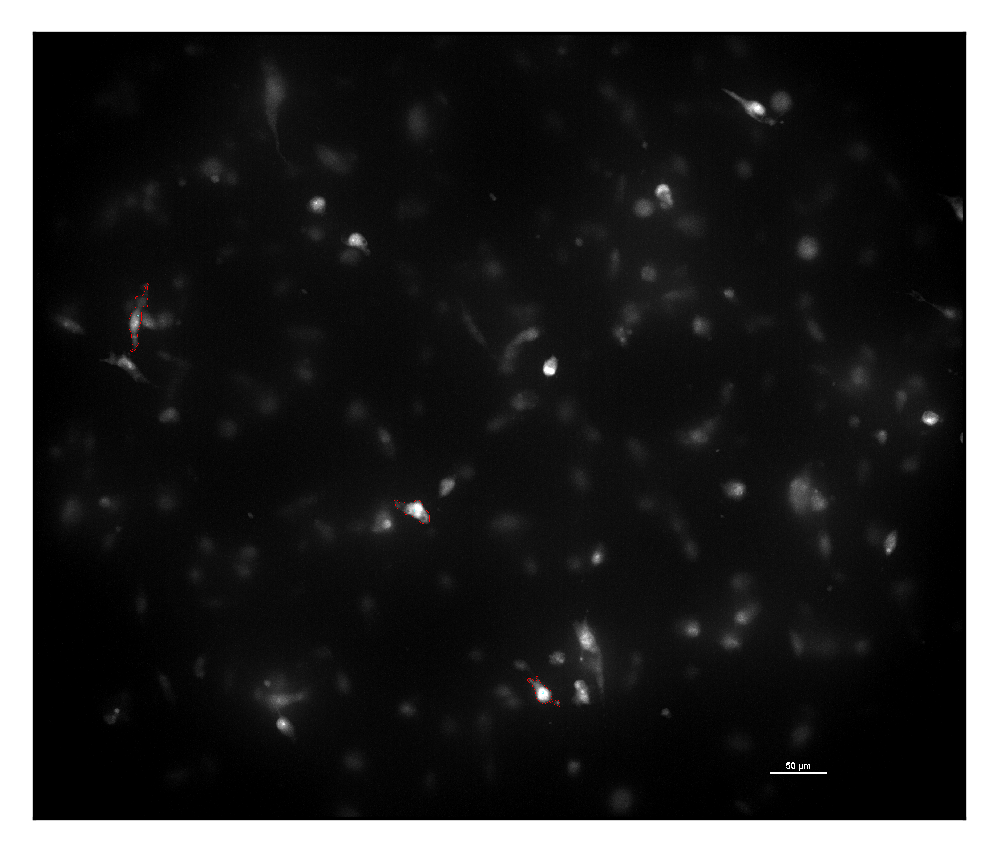

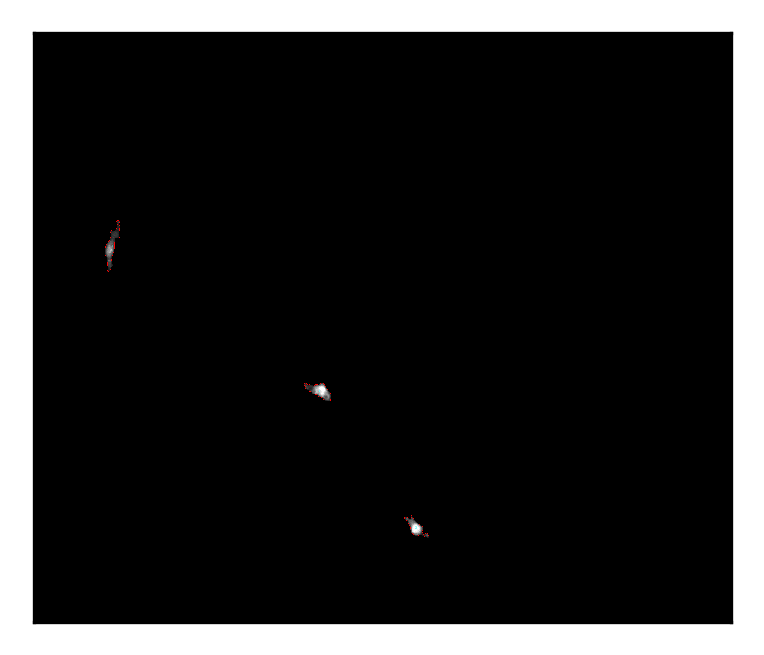

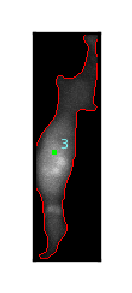

In [10]:
get_cell_img(42, debug=1);

In [11]:
def find_cell_img(cid, debug):
    
    imgpath = os.sep.join(['CellImgs', repr(cid) + '.png'])
    img = io.imread(imgpath)
    
    if debug == 1:
        
        plt.figure(figsize=(1,1), dpi=300)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.show()
        
    return img

def plot_cell_montage(cid_list, msize):
    
    imgs = []
    cids = []
    for cid in cid_list:
        imgpath = os.sep.join(['CellImgs', repr(cid) + '.png'])
        try:
            img = io.imread(imgpath)
        except:
            continue
        if ((np.shape(img)[0] == 2160) and (np.shape(img)[1] == 2560)):
                continue
        imgs.append(img)
        cids.append(cid)
    s = ''
    cap = ''
    for i in range(len(imgs)):
        s += ' <img style = "width: auto; height: auto; margin: ' + str(msize) + 'px; float: left; border: 1px solid black;" '
        s += ' src = "CellImgs' + os.sep + repr(cids[i]) + '.png" />'
        if ((i+1) % 5) == 0:
            s += '<br/><br/><br/><br/><br/><br/>'
            s += cap
            s += '<br/><br/>'
            cap = ''
    s += cap
    return (cids, s)

In [12]:
#print "Plotting single cell:"
#find_cell_img(543, debug=1);

(cid_plots, html_string) = plot_cell_montage([30, 31, 32, 174, 175, 176], 5)
print "Plotting: " + repr(cid_plots) + "(examples of overlapping cells)"
display(HTML(html_string))

Plotting: [30, 31, 32, 174, 175, 176](examples of overlapping cells)


In [13]:
numcells = np.shape(CP_data)[0]
cell_imgs = []

err_str = "No images for cell IDs: "

for itr in range(numcells):
    
    res = None
    try:
        res = find_cell_img(itr, debug=0)
        cell_imgs.append(res)
    except:
        err_str += repr(itr) + " "
        cell_imgs.append(None)
print err_str

No images for cell IDs: 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665 666 667 668 669 670 671 


#### Count number of images segmented

In [14]:
print "Number of cells in feature matrix: " + repr(numcells)

num_imgs = sum(c_img is not None for c_img in cell_imgs)
print "Number of segmented cell images available: " + repr(num_imgs)

Number of cells in feature matrix: 672
Number of segmented cell images available: 501


#### Classify cells by compactness

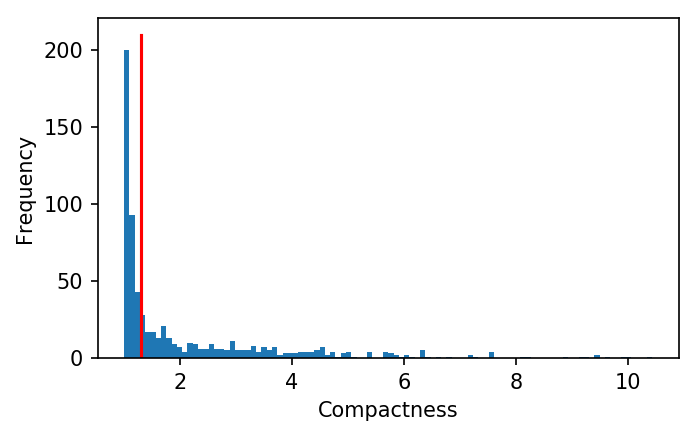

In [17]:
compactness_arr = np.asarray(CP_data['AreaShape_Compactness'])
mu = float(np.mean(compactness_arr))
std_dev = float(np.std(compactness_arr))
compactness_scored = [(c - mu)/std_dev for c in compactness_arr]

plt.figure(figsize=(5,3), dpi=150)
plt.hist(compactness_arr, bins=100)
axes = plt.gca()
y_limit = axes.get_ylim()
plt.plot([1.3, 1.3], [0, y_limit[1]], 'r')

plt.xlabel('Compactness')
plt.ylabel('Frequency')

majority = np.where(np.asarray(compactness_scored) < 0.0)[0]
transitory = np.where((np.asarray(compactness_scored) > 0.0) & (np.asarray(compactness_scored) < 2.0))[0]
outliers = np.where(np.asarray(compactness_scored) > 2.0)[0]

In [18]:
compactness_thresh_vals = [1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4]
amoeboid_acc_vals = list()
mesenchymal_acc_vals = list()

for compactness_thresh in compactness_thresh_vals:
    
    print 'Using threshold: ' + repr(compactness_thresh)
    
    compactness_arr = np.asarray(CP_data['AreaShape_Compactness'])
    gt_labels = CP_data['label']

    pred_ameboid = np.where(np.asarray(compactness_arr) < compactness_thresh)[0]
    num_pred_amoeboid = np.sum(gt_labels[pred_ameboid] == 'amoeboidCells')
    num_true_amoeboid = np.sum(gt_labels == 'amoeboidCells') 
    amoeboid_acc = np.true_divide(num_pred_amoeboid, num_true_amoeboid)
    print 'Amoeboid classification accuracy: ' + repr(amoeboid_acc)

    pred_mesenchymal = np.where(np.asarray(compactness_arr) >= compactness_thresh)[0]
    num_pred_mesenchymal = np.sum(gt_labels[pred_mesenchymal] == 'mesenchymalCells')
    num_true_mesenchymal = np.sum(gt_labels == 'mesenchymalCells')
    mesenchymal_acc = np.true_divide(num_pred_mesenchymal, num_true_mesenchymal)
    print 'Mesenchymal classification accuracy: ' + repr(mesenchymal_acc)
    
    amoeboid_acc_vals.append(amoeboid_acc)
    mesenchymal_acc_vals.append(mesenchymal_acc)
    
    print ""

Using threshold: 1.1
Amoeboid classification accuracy: 0.58125
Mesenchymal classification accuracy: 0.9431818181818182

Using threshold: 1.15
Amoeboid classification accuracy: 0.721875
Mesenchymal classification accuracy: 0.9289772727272727

Using threshold: 1.2
Amoeboid classification accuracy: 0.828125
Mesenchymal classification accuracy: 0.9034090909090909

Using threshold: 1.25
Amoeboid classification accuracy: 0.890625
Mesenchymal classification accuracy: 0.8806818181818182

Using threshold: 1.3
Amoeboid classification accuracy: 0.921875
Mesenchymal classification accuracy: 0.8636363636363636

Using threshold: 1.35
Amoeboid classification accuracy: 0.95
Mesenchymal classification accuracy: 0.8522727272727273

Using threshold: 1.4
Amoeboid classification accuracy: 0.9625
Mesenchymal classification accuracy: 0.8267045454545454



/home/labmember/anaconda2/lib/python2.7/site-packages/pandas/core/series.py:842: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



Text(0.5,0,u'Compactness Threshold')

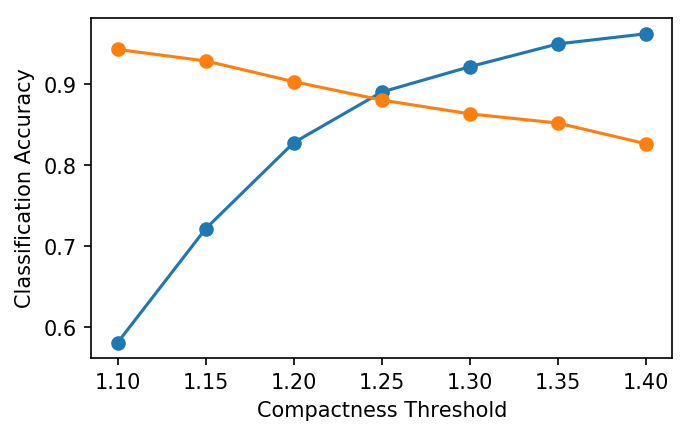

In [20]:
plt.figure(figsize=(5,3), dpi=150)
plt.plot(compactness_thresh_vals, amoeboid_acc_vals, '-o', label='Amoeboid')
plt.plot(compactness_thresh_vals, mesenchymal_acc_vals, '-o', label='Mesenchymal')
plt.ylabel('Classification Accuracy')
plt.xlabel('Compactness Threshold')

#### Compact morphologies

In [22]:
random_majority = np.random.choice(majority, 10, replace = False)
print "Random selection: " + repr(random_majority)
(cid_plots, html_string) = plot_cell_montage(random_majority, 5)
print "Plotting: " + repr(cid_plots)
display(HTML(html_string))

Random selection: array([336, 463, 337, 551, 297, 413, 172, 423, 486, 232])
Plotting: [336, 463, 337, 297, 413, 172, 423, 486]


#### Elongated morphologies

In [23]:
random_transitory = np.random.choice(transitory, 10, replace = False)
print "Random selection: " + repr(random_transitory)
(cid_plots, html_string) = plot_cell_montage(random_transitory, 5)
print "Plotting: " + repr(cid_plots)
display(HTML(html_string))

Random selection: array([497, 670, 607, 606, 535, 258, 100,  35, 422,  68])
Plotting: [497, 535, 258, 100, 35, 422, 68]


#### Outlier morphologies

In [24]:
random_outliers = np.random.choice(outliers, 10, replace = False)
print "Random selection: " + repr(random_outliers)
(cid_plots, html_string) = plot_cell_montage(random_outliers, 5)
print "Plotting: " + repr(cid_plots)
display(HTML(html_string))

Random selection: array([660, 225, 490, 124, 238, 270, 119,  16, 618,  23])
Plotting: [490, 270, 23]


#### 3D plot of Max. Feret Diameter, Min. Feret Diameter and Compactness

In [26]:
feat_data = CP_data[['AreaShape_MaxFeretDiameter', 'AreaShape_MinFeretDiameter', 'AreaShape_Compactness']]
cols = feat_data.columns
feat_data[cols] = feat_data[cols].apply(pd.to_numeric, errors = 'coerce')

X = feat_data.values
X_std = np.true_divide((X - X.mean(0)), np.sqrt(X.var(0)))
print X_std.shape

plt_data = []
cnt = 0
for well in np.unique(CP_data['label']):
    
    well_UID = CP_data[CP_data['label'] == well].index
    all_UID = list(CP_data.index)
    ind = []
    
    for UID in well_UID:
        ind.append(all_UID.index(UID))   

    trace = go.Scatter3d(
                name = well,
                x = X[ind, 0],
                y = X[ind, 1],
                z = X[ind, 2],
                mode = 'markers',
                text = ind,
                marker = dict(
                    color = cnt,
                    size = 8,
                    symbol = 'circle',
                    line = dict(
                        color = 'rgb(180, 180, 180)',
                        width = 1.0
                    ),
                    opacity = 0.4
                )
            )

    plt_data.append(trace)
    cnt += 1
        
layout = go.Layout(
    margin = dict(l = 0, r = 0, b = 0, t = 0)
)

fig = go.Figure(data=plt_data, layout=layout)
iplot(fig)

(672, 3)
